# AAPL Stock Price Prediction
- Data source: https://finance.yahoo.com/quote/AAPL/history?p=AAPL <br>
- Paper: [EMA VERSUS SMA USAGE TO FORECAST STOCK MARKETS: THE CASE OF S&P 500 AND OMX BALTIC BENCHMARK](https://doi.org/10.3846/btp.2010.27) <br>

### Goal:
- **Task 1:** According to the research paper, analyze EMA and SMA which is best feature to forecast stock price by applying the following models. 
    - Linear Regression
    - Ridge Regression
    - Lasso Regression
- **Task 2:** Based on the EMA and SMA analysis results, to predict the APPL stock price in the following three regression models.
    - Linear Regression
    - Prophet
    - Long Short Term Memory (LSTM)


## Imports libraries

In [5]:
import math
import numpy as np
import pandas as pd
import pandas_ta as ta
import prophet
import tensorflow as tf
import matplotlib.pyplot as plt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from tensorflow import keras
%matplotlib inline

## Load and explore the data

In [42]:
# Import data from csv file to a pandas dataframe
df = pd.read_csv("AAPL.csv")
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2010-03-17,8.0321430000,8.0875000000,7.9739290000,8.0042860000,6.8538650000,450956800
1,2010-03-18,8.0035710000,8.0357140000,7.9503570000,8.0232140000,6.8700740000,342109600
2,2010-03-19,8.0282140000,8.0442860000,7.9010710000,7.9375000000,6.7966780000,559445600
3,2010-03-22,7.8739290000,8.0714290000,7.8625000000,8.0267860000,6.8731320000,456419600
4,2010-03-23,8.0585710000,8.1707140000,8.0035710000,8.1557140000,6.9835300000,602431200


In [43]:
# Import SMA data
df.ta.sma(close='Adj_Close', length=2, append=True)
df.ta.sma(close='Adj_Close', length=50, append=True)
df.ta.sma(close='Adj_Close', length=200, append=True)

# Import EMA data
df.ta.ema(close='Adj_Close', length=2, append=True)
df.ta.ema(close='Adj_Close', length=50, append=True)
df.ta.ema(close='Adj_Close', length=200, append=True)

# Import HL_PCT data
df['HL_PCT'] = (df['High'] - df['Adj_Close']) / df['Adj_Close'] * 100.0

# Import PCT_change data
df['PCT_change'] = (df['Adj_Close'] - df['Open']) / df['Open'] * 100.0

In [44]:
# remove NaN data and preview the cleaned data
df.dropna(axis=0, inplace=True)
df = df.reset_index(drop=True)
df

,Date,Open,High,Low,Close,Adj_Close,Volume,SMA_2,SMA_50,SMA_200,EMA_2,EMA_50,EMA_200,HL_PCT,PCT_change
0,2010-12-29,11.6507140000,11.6589290000,11.6107140000,11.6175000000,9.9477680000,163139200,9.9505190000,9.6256068200,8.3312760800,9.9460585365,9.5553256979,8.3312760800,17.2014566484,-14.6166664120
1,2010-12-30,11.6242860000,11.6253570000,11.5375000000,11.5592860000,9.8979180000,157494400,9.9228430000,9.6342734600,8.3464963450,9.9139648455,9.5687606902,8.3468645568,17.4525491118,-14.8513895821
2,2010-12-31,11.5339290000,11.5528570000,11.4753570000,11.5200000000,9.8642810000,193508000,9.8810995000,9.6416312800,8.3614673800,9.8808422818,9.5803497219,8.3619632279,17.1180849370,-14.4759691169
3,2011-01-03,11.6300000000,11.7950000000,11.6014290000,11.7703570000,10.0786550000,445138400,9.9714680000,9.6538943600,8.3778772650,10.0127174273,9.5998911054,8.3790447381,17.0295044329,-13.3391659501
4,2011-01-04,11.8728570000,11.8750000000,11.7196430000,11.8317860000,10.1312560000,309080800,10.1049555000,9.6684632600,8.3941678850,10.0917431424,9.6207289444,8.3964796760,17.2115283633,-14.6687608551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,2022-03-10,160.1999970000,160.3899990000,155.9799960000,158.5200040000,158.5200040000,105342000,160.7350005000,169.0170074000,153.1293794250,159.5128607659,166.3256955227,154.1976520001,1.1796586884,-1.0486847887
2819,2022-03-11,158.9299930000,159.2799990000,154.5000000000,154.7299960000,154.7299960000,96836300,156.6250000000,168.5285723400,153.2714558800,156.3242842553,165.8709622081,154.2029489553,2.9406082322,-2.6426711036
2820,2022-03-14,151.4499970000,154.1199950000,150.1000060000,150.6199950000,150.6199950000,108732100,152.6749955000,167.9815072200,153.4007991800,152.5214247518,165.2728850626,154.1672976721,2.3237286656,-0.5480369868
2821,2022-03-15,150.8999940000,155.5700070000,150.3800050000,155.0899960000,155.0899960000,92964300,152.8549955000,167.5364260400,153.5558283600,154.2338055839,164.8735560798,154.1764787500,0.3095048116,2.7766747294


# Task 1: Analyze SMA vs. EMA Forecasting Methods

## 1.1 SMA
### 1.1.1 Data Preprocessing - SMA
In this section, I focus on making the data ready to use for ML models. It includes:
- split the data into training and testing by 70:30 ratio
- assign a random state for reproducible output

In [45]:
# Import data
df_sma = df[['Date', 'Adj_Close', 'SMA_2', 'SMA_50', 'SMA_200']]
df_sma.head()

,Date,Adj_Close,SMA_2,SMA_50,SMA_200
0,2010-12-29,9.9477680000,9.9505190000,9.6256068200,8.3312760800
1,2010-12-30,9.8979180000,9.9228430000,9.6342734600,8.3464963450
2,2010-12-31,9.8642810000,9.8810995000,9.6416312800,8.3614673800
3,2011-01-03,10.0786550000,9.9714680000,9.6538943600,8.3778772650
4,2011-01-04,10.1312560000,10.1049555000,9.6684632600,8.3941678850


In [46]:
#split data into 70% training and 30% testing
features_sma = ['SMA_2', 'SMA_50', 'SMA_200']
X_sma = df_sma[features_sma]
y_sma = df_sma['Adj_Close']
X_train_sma, X_test_sma, y_train_sma, y_test_sma = train_test_split(X_sma, y_sma, test_size=0.3, random_state=55)

print(X_train_sma.shape)
print(X_test_sma.shape)
print(y_train_sma.shape)
print(y_test_sma.shape)

(1976, 3)
(847, 3)
(1976,)
(847,)


### 1.1.2 Model Selection - SMA
In this section, I focus on compare three regression models and make decision which regression model is more adequate. It includes:
- fit the regression model (linear/lasso/ridge) on the training set 
- calculate score of Linear Regression
- calculate score of Ridge Regression
- calculate score of Lasso Regression
- compare the three models in descending order

In [47]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_sma, y_train_sma)
score_reg_sma = lin_reg.score(X_test_sma, y_test_sma)

# Ridge Regression
lin_rng = Ridge()
lin_rng.fit(X_train_sma, y_train_sma)
score_rng_sma = lin_rng.score(X_test_sma, y_test_sma)

# Lasso Regression
lin_las = Lasso()
lin_las.fit(X_train_sma, y_train_sma)
score_las_sma = lin_las.score(X_test_sma, y_test_sma)

In [49]:
# Compare three regression models
print('Using Linear Regression model in model training, because the score of Linear Regression is the highest.')
score_sma = {'score_SMA': [score_reg_sma, score_rng_sma, score_las_sma]}
df_score = pd.DataFrame(score_sma, index=['Linear', 'Ridge', 'Lasso'])
pd.set_option('display.float_format', '{:.10f}'.format)
df_score.sort_values(['score_SMA'], ascending=False)

Using Linear Regression model in model training, because the score of Linear Regression is the highest.


,score_SMA
Linear,0.9997931612
Ridge,0.9997931604
Lasso,0.9997910935


### 1.1.3 Model Training - SMA
In this section, I focus on model training process:
- implement Linear Regression model
- make predictions

In [13]:
# Predict stock prices based on SMA
forecasts_sma = lin_reg.predict(X_test_sma)
forecasts_all_sma = lin_reg.predict(X_sma)
pd.set_option('display.float_format', '{:.6f}'.format)
df_sma.insert(4, "Predicted_Price_SMA", forecasts_all_sma, True)
df_sma[['Date', 'Adj_Close', 'Predicted_Price_SMA']].reset_index(drop=True)

,Date,Adj_Close,Predicted_Price_SMA
0,2010-12-29,9.947768,9.939418
1,2010-12-30,9.897918,9.911237
2,2010-12-31,9.864281,9.868795
3,2011-01-03,10.078655,9.960441
4,2011-01-04,10.131256,10.095828
...,...,...,...
2818,2022-03-10,158.520004,160.658204
2819,2022-03-11,154.729996,156.496063
2820,2022-03-14,150.619995,152.497670
2821,2022-03-15,155.089996,152.692023


### 1.1.4 Model Interpretation - SMA
In this section, I focus on error analysis.

In [14]:
MSE_sma = metrics.mean_squared_error(y_test_sma, forecasts_sma).round(3)
MAE_sma = metrics.mean_absolute_error(y_test_sma, forecasts_sma).round(3)
RMSE_sma = np.sqrt(metrics.mean_squared_error(y_test_sma, forecasts_sma)).round(3)

## 1.2 EMA
### 1.2.1 Data Preprocessing - EMA
In this section, I focus on making the data ready to use for ML models. It includes:
- split the data into training and testing by 70:30 ratio
- assign a random state for reproducible output

In [50]:
# Import data
df_ema = df[['Date', 'Adj_Close', 'EMA_2', 'EMA_50', 'EMA_200']]
df_ema.head()

,Date,Adj_Close,EMA_2,EMA_50,EMA_200
0,2010-12-29,9.9477680000,9.9460585365,9.5553256979,8.3312760800
1,2010-12-30,9.8979180000,9.9139648455,9.5687606902,8.3468645568
2,2010-12-31,9.8642810000,9.8808422818,9.5803497219,8.3619632279
3,2011-01-03,10.0786550000,10.0127174273,9.5998911054,8.3790447381
4,2011-01-04,10.1312560000,10.0917431424,9.6207289444,8.3964796760


In [51]:
# Split data into 70% training and 30% testing
features_ema = ['EMA_2', 'EMA_50', 'EMA_200']
X_ema = df_ema[features_ema]
y_ema = df_ema['Adj_Close']
X_train_ema, X_test_ema, y_train_ema, y_test_ema = train_test_split(X_ema, y_ema, test_size=0.3, random_state=55)

# After splitting
print(X_train_ema.shape)
print(X_test_ema.shape)
print(y_train_ema.shape)
print(y_test_ema.shape)

(1976, 3)
(847, 3)
(1976,)
(847,)


### 1.2.2 Model Selection - EMA
In this section, I focus on compare three regression models and make decision which regression model is more adequate. It includes:
- fit the regression model (linear/lasso/ridge) on the training set 
- calculate score of Linear Regression
- calculate score of Ridge Regression
- calculate score of Lasso Regression
- compare the three models in descending order

In [52]:
# Linear Regression
lin_reg.fit(X_train_ema, y_train_ema)
score_reg_ema = lin_reg.score(X_test_ema, y_test_ema)

# Ridge Regression
lin_rng.fit(X_train_ema, y_train_ema)
score_rng_ema = lin_rng.score(X_test_ema, y_test_ema)

# Lasso Regression
lin_las.fit(X_train_ema, y_train_ema)
score_las_ema = lin_las.score(X_test_ema, y_test_ema)

In [53]:
# Compare three regression models
print('Using Linear Regression model in model training, because the score of Linear Regression is the highest.')
score_ema = {'score_EMA': [score_reg_ema, score_rng_ema, score_las_ema]}
df_score = pd.DataFrame(score_ema, index=['Linear', 'Ridge', 'Lasso'])
pd.set_option('display.float_format', '{:.10f}'.format)
df_score.sort_values(['score_EMA'], ascending=False)

Using Linear Regression model in model training, because the score of Linear Regression is the highest.


,score_EMA
Linear,0.9999077657
Ridge,0.9999077638
Lasso,0.9998956294


### 1.2.3 Model Training - EMA
In this section, I focus on model training process:
- implement Linear Regression model
- make predictions

In [54]:
# Predict stock prices based on EMA
forecasts_ema = lin_reg.predict(X_test_ema)
forecasts_all_ema = lin_reg.predict(X_ema)
pd.set_option('display.float_format', '{:.6f}'.format)
df_ema.insert(4, "Predicted_Price_EMA", forecasts_all_ema, True)
df_ema[['Date', 'Adj_Close', 'Predicted_Price_EMA']].reset_index(drop=True)

,Date,Adj_Close,Predicted_Price_EMA
0,2010-12-29,9.947768,9.923178
1,2010-12-30,9.897918,9.889206
2,2010-12-31,9.864281,9.854273
3,2011-01-03,10.078655,9.990973
4,2011-01-04,10.131256,10.072463
...,...,...,...
2818,2022-03-10,158.520004,159.214555
2819,2022-03-11,154.729996,155.919565
2820,2022-03-14,150.619995,151.992456
2821,2022-03-15,155.089996,153.806357


### 1.2.4 Model Interpretation - EMA
In this section, I focus on error analysis.

In [55]:
MSE_ema = metrics.mean_squared_error(y_test_ema, forecasts_ema).round(3)
MAE_ema = metrics.mean_absolute_error(y_test_ema, forecasts_ema).round(3)
RMSE_ema = np.sqrt(metrics.mean_squared_error(y_test_ema, forecasts_ema)).round(3)

## 1.3 Comparison Results for SMA vs. EMA
In this section, I focus on comparing mean absolute errors of SMA and EMA, and make decision which feature is more adequate to predict stock price.

In [56]:
data_error = {'SMA': [MSE_sma, MAE_sma, RMSE_sma], 'EMA': [MSE_ema, MAE_ema, RMSE_ema]}
df_error = pd.DataFrame(data_error, index=['Mean Squared Error (MSE)', 
                                           'Mean Absolute Error (MAE)', 
                                           'Root Mean Squared Error (RMSE)'])
pd.set_option('display.float_format', '{:.3f}'.format)
print("Using EMA method in stock prices prediction, because the MAE of EMA is lower than SMA's")
df_error

Using EMA method in stock prices prediction, because the MAE of EMA is lower than SMA's


,SMA,EMA
Mean Squared Error (MSE),0.374,0.167
Mean Absolute Error (MAE),0.312,0.212
Root Mean Squared Error (RMSE),0.612,0.409


# Task 2: APPL Stock Price Prediction Based on EMA Method
In this task, I focus on the following three models to forecast stock price:
- Linear Regression
- Prophet
- Long Short Term Memory (LSTM)


## 2.1 Linear Regression
### 2.1.1 Data Preprocessing - Linear Regression
In this section, I focus on making the data ready to use for ML models. It includes:
- feature representation to determine which feature will be used in model training
- split the data into training and testing by 70:30 ratio
- assign a random state for reproducible output

In [57]:
# Import data
pd.set_option('display.float_format', '{:.6f}'.format)
df = df[['Date', 'Open', 'High', 'Low', 'Adj_Close', 'EMA_2', 'EMA_50', 'EMA_200', 'HL_PCT', 'PCT_change', 'Volume']]
df

,Date,Open,High,Low,Adj_Close,EMA_2,EMA_50,EMA_200,HL_PCT,PCT_change,Volume
0,2010-12-29,11.650714,11.658929,11.610714,9.947768,9.946059,9.555326,8.331276,17.201457,-14.616666,163139200
1,2010-12-30,11.624286,11.625357,11.537500,9.897918,9.913965,9.568761,8.346865,17.452549,-14.851390,157494400
2,2010-12-31,11.533929,11.552857,11.475357,9.864281,9.880842,9.580350,8.361963,17.118085,-14.475969,193508000
3,2011-01-03,11.630000,11.795000,11.601429,10.078655,10.012717,9.599891,8.379045,17.029504,-13.339166,445138400
4,2011-01-04,11.872857,11.875000,11.719643,10.131256,10.091743,9.620729,8.396480,17.211528,-14.668761,309080800
...,...,...,...,...,...,...,...,...,...,...,...
2818,2022-03-10,160.199997,160.389999,155.979996,158.520004,159.512861,166.325696,154.197652,1.179659,-1.048685,105342000
2819,2022-03-11,158.929993,159.279999,154.500000,154.729996,156.324284,165.870962,154.202949,2.940608,-2.642671,96836300
2820,2022-03-14,151.449997,154.119995,150.100006,150.619995,152.521425,165.272885,154.167298,2.323729,-0.548037,108732100
2821,2022-03-15,150.899994,155.570007,150.380005,155.089996,154.233806,164.873556,154.176479,0.309505,2.776675,92964300


### Feature Representation

In [64]:
# Split data into 70% training and 30% testing
features = ['Open', 'High', 'Low', 'EMA_2', 'EMA_50', 'EMA_200', 'HL_PCT', 'PCT_change', 'Volume']
X = df[features]
y = df['Adj_Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

# After splitting
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1976, 9)
(847, 9)
(1976,)
(847,)


In [65]:
# Print the feature importance in coefficient descending order.
lin_reg.fit(X_train, y_train)
score = lin_reg.score(X_train, y_train)
coeff_df = pd.DataFrame(lin_reg.coef_,
                        X.columns,
                        columns=['Coefficient_Linear'])
print('Using EMA_2 as feature in the three models, because EMA_2 has the highest coefficient.')
coeff_df.sort_values(['Coefficient_Linear'], ascending=False).round(6)

Using EMA_2 as feature in the three models, because EMA_2 has the highest coefficient.


,Coefficient_Linear
EMA_2,0.914524
Low,0.286207
High,0.241587
EMA_200,0.019377
Volume,0.000000
PCT_change,-0.001580
HL_PCT,-0.016379
EMA_50,-0.048907
Open,-0.410152


In [66]:
# Split data into 70% training and 30% testing
features_lin = ['Open', 'High', 'Low', 'EMA_2', 'EMA_50', 'EMA_200']
X_lin = df[features_lin]
y_lin = df['Adj_Close']
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.3, random_state=55)

# After splitting
print(X_train_lin.shape)
print(X_test_lin.shape)
print(y_train_lin.shape)
print(y_test_lin.shape)

(1976, 6)
(847, 6)
(1976,)
(847,)


In [68]:
df[['Open', 'High', 'Low', 'EMA_2', 'EMA_50', 'EMA_200', 'Adj_Close']]

,Open,High,Low,EMA_2,EMA_50,EMA_200,Adj_Close
0,11.650714,11.658929,11.610714,9.946059,9.555326,8.331276,9.947768
1,11.624286,11.625357,11.537500,9.913965,9.568761,8.346865,9.897918
2,11.533929,11.552857,11.475357,9.880842,9.580350,8.361963,9.864281
3,11.630000,11.795000,11.601429,10.012717,9.599891,8.379045,10.078655
4,11.872857,11.875000,11.719643,10.091743,9.620729,8.396480,10.131256
...,...,...,...,...,...,...,...
2818,160.199997,160.389999,155.979996,159.512861,166.325696,154.197652,158.520004
2819,158.929993,159.279999,154.500000,156.324284,165.870962,154.202949,154.729996
2820,151.449997,154.119995,150.100006,152.521425,165.272885,154.167298,150.619995
2821,150.899994,155.570007,150.380005,154.233806,164.873556,154.176479,155.089996


### 2.1.2 Model Training - Linear Regression
In this section, I focus on model training process:
- implement Linear Regression model
- fit the Linear Regression model on the training set
- make predictions

In [26]:
# Fit the model
lin_reg.fit(X_train_lin, y_train_lin)

# Stock Prediction
forecasts_lin = lin_reg.predict(X_test_lin)
forecasts_all_lin = lin_reg.predict(X_lin)
df.insert(1, "Predicted_Price", forecasts_all_lin, True)
df[['Date', 'Adj_Close', 'Predicted_Price']].reset_index(drop=True)

,Date,Adj_Close,Predicted_Price
0,2010-12-29,9.947768,9.869072
1,2010-12-30,9.897918,9.821472
2,2010-12-31,9.864281,9.793499
3,2011-01-03,10.078655,9.967968
4,2011-01-04,10.131256,9.992237
...,...,...,...
2818,2022-03-10,158.520004,158.308489
2819,2022-03-11,154.729996,155.192004
2820,2022-03-14,150.619995,152.331690
2821,2022-03-15,155.089996,154.604155


### 2.1.3 Model Interpretation - Linear Regression
In this section, I focus on error analysis.

# Error Analysis
MSE_lin = metrics.mean_squared_error(y_test_lin, forecasts_lin)
MAE_lin = metrics.mean_absolute_error(y_test_lin, forecasts_lin)
RMSE_lin = np.sqrt(metrics.mean_squared_error(y_test_lin, forecasts_lin))

data_error_lin = {'Linear Regression': [MSE_lin, MAE_lin, RMSE_lin]}
df_error_lin = pd.DataFrame(data_error_lin, index=['Mean Squared Error (MSE)', 
                                               'Mean Absolute Error (MAE)', 
                                               'Root Mean Squared Error (RMSE)'])
pd.set_option('display.float_format', '{:.3f}'.format)
df_error_lin

### 2.1.4 Model Visualization - Linear Regression
In this section, I focus on visualize stock price prediction result.

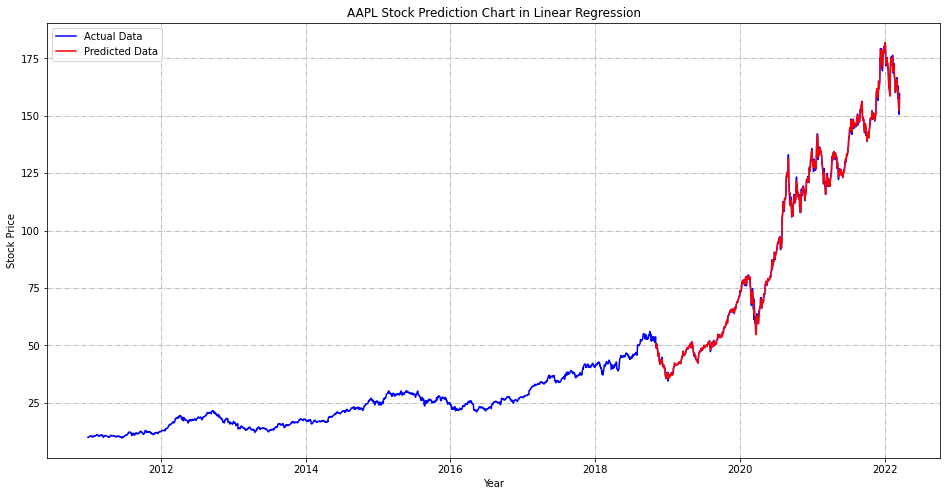

In [29]:
# df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']
test = df[1976:]

plt.figure(figsize=(16, 8))
plt.plot(df.Adj_Close, color='blue', label='Actual Data')
plt.plot(test.Predicted_Price, color='red', label='Predicted Data')
plt.setp(plt.gca().get_xticklabels(), rotation=0)
  
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.title("AAPL Stock Prediction Chart in Linear Regression")
plt.legend()
plt.grid(linestyle='-.')
plt.show()

## 2.2 Prophet
### 2.2.1 Data Preprocessing - Prophet
In this section, I focus on making the data ready to use for ML models. It includes:
- split the data into training and testing by 70:30 ratio
- assign a random state for reproducible output

In [30]:
# Create dataframe
data_p = df.sort_index(ascending=True, axis=0)
new_data_p = pd.DataFrame(index=range(0, len(df)), columns=['EMA_2', 'Adj_Close'])

for i in range(0,len(data_p)):
    new_data_p['EMA_2'][i] = data_p['EMA_2'][i]
    new_data_p['Adj_Close'][i] = data_p['Adj_Close'][i]

new_data_p.rename(columns={'Adj_Close': 'y', 'EMA_2': 'ds'}, inplace=True)

# Split data into 70% training and 30% testing
train_p = new_data_p[:1976]
test_p = new_data_p[1976:]

### 2.2.2 Model Training - Prophet
In this section, I focus on model training process:
- implement Prophet model
- fit the Prophet model on the training set
- make predictions

In [31]:
# Fit the model
fbp = Prophet()
fbp.fit(train_p)

# Stock Prediction
forecast_data_p = test_p[['ds']]
forecasts_p = fbp.predict(forecast_data_p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9237.47   0.000926815        1272.8           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9238.35    0.00315651       428.298           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9239.03   6.67875e-05       246.664      0.6634      0.6634      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9239.13   0.000282129       111.663           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       9239.14   3.36157e-06       175.185   4.533e-08       0.001      582  LS failed, Hessian reset 
     457       9239.14   1.38409e-06      

### 2.2.3 Model Interpretation - Prophet
In this section, I focus on error analysis.

In [32]:
# Error Analysis
forecast_valid = forecasts_p['yhat']
MSE_p = metrics.mean_squared_error(test_p['y'], forecast_valid)
MAE_p = metrics.mean_absolute_error(test_p['y'], forecast_valid)
RMSE_p = np.sqrt(metrics.mean_squared_error(test_p['y'], forecast_valid))

data_error_p = {'Prophet': [MSE_p, MAE_p, RMSE_p]}
df_error_p = pd.DataFrame(data_error_p, index=['Mean Squared Error (MSE)', 
                                               'Mean Absolute Error (MAE)', 
                                               'Root Mean Squared Error (RMSE)'])
pd.set_option('display.float_format', '{:.3f}'.format)
df_error_p

,Prophet
Mean Squared Error (MSE),40.484
Mean Absolute Error (MAE),4.618
Root Mean Squared Error (RMSE),6.363


### 2.2.4 Model Visualization - Prophet
In this section, I focus on visualize stock price prediction result.

/var/folders/0j/h3cqhtvd08g48k364rs9wzm40000gn/T/ipykernel_12737/2305296962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_p['Predictions'] = forecast_valid.values


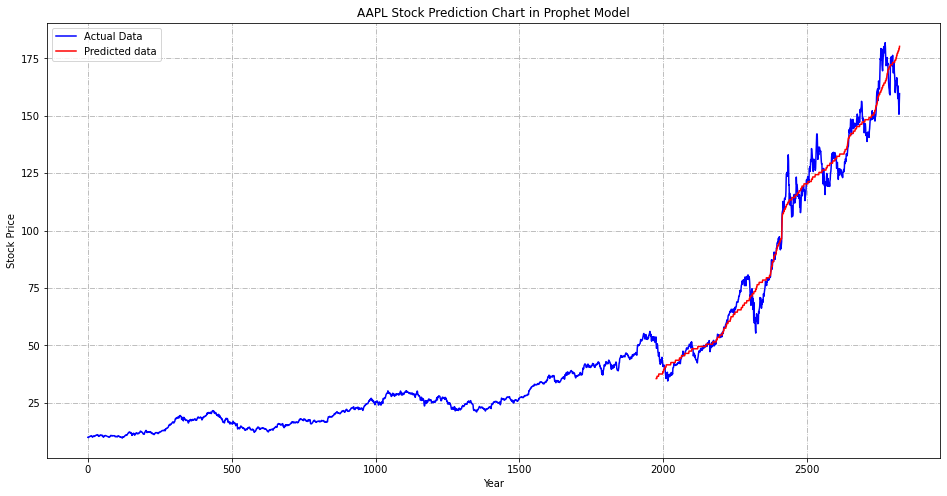

In [33]:
test_p['Predictions'] = forecast_valid.values

plt.figure(figsize=(16, 8))
plt.plot(new_data_p['y'], color='blue', label='Actual Data')
plt.plot(test_p['Predictions'], color='red', label='Predicted data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.title("AAPL Stock Prediction Chart in Prophet Model")
plt.legend()
plt.grid(linestyle='-.')
plt.show()

## 2.3 LSTM
### 2.3.1 Data Preprocessing - LSTM
In this section, I focus on making the data ready to use for LSTM models. It includes:
- setting index
- process features with MinMaxScaler 
- split the data into training and testing by 70:30 ratio
- assign a random state for reproducible output

In [34]:
# Import dataset
data_lstm = df.sort_index(ascending=True, axis=0)
new_data_lstm = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj_Close'])
for i in range(0,len(data_lstm)):
    new_data_lstm['Date'][i] = data_lstm['Date'][i]
    new_data_lstm['Adj_Close'][i] = data_lstm['EMA_2'][i]

# Set index
new_data_lstm.index = new_data_lstm.Date
new_data_lstm.drop('Date', axis=1, inplace=True)

# Split data into 70% training and 30% testing
dataset_lstm = new_data_lstm.values
train_lstm = dataset_lstm[0:1976, :]
test_lstm = dataset_lstm[1976:, :]

# Convert into X_train and y_train
minmax = MinMaxScaler(feature_range=(0, 1))
scaled_data = minmax.fit_transform(dataset_lstm)

X_train_lstm, y_train_lstm = [], []
for i in range(2, len(train_lstm)):
    X_train_lstm.append(scaled_data[i-2:i, 0])
    y_train_lstm.append(scaled_data[i, 0])
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

### 2.3.2 Model Training - LSTM
In this section, I focus on model training process:
- implement LSTM model
- fit the LSTM model on the training set
- make predictions

In [35]:
# Set up LSTM network
seq = Sequential()
seq.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
seq.add(LSTM(units=50))
seq.add(Dense(1))
seq.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
seq.fit(X_train_lstm, y_train_lstm, epochs=1, batch_size=1, verbose=2)
inputs = new_data_lstm[len(new_data_lstm) - len(test_lstm) - 2:].values
inputs = inputs.reshape(-1, 1)
inputs = minmax.transform(inputs)

X_test_lstm = []
for i in range(2, inputs.shape[0]):
    X_test_lstm.append(inputs[i-2:i, 0])
    
# Stock Prediction
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1],1))
forecasts_lstm = seq.predict(X_test_lstm)
forecasts_lstm = minmax.inverse_transform(forecasts_lstm)

2022-03-18 18:10:42.765865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1974/1974 - 6s - loss: 2.1498e-04 - 6s/epoch - 3ms/step


### 2.3.3 Model Interpretation - LSTM
In this section, I focus on error analysis.

In [36]:
# Error Analysis
MSE_lstm = metrics.mean_squared_error(test_lstm, forecasts_lstm)
MAE_lstm = metrics.mean_absolute_error(test_lstm, forecasts_lstm)
RMSE_lstm = np.sqrt(metrics.mean_squared_error(test_lstm, forecasts_lstm))

data_error_lstm = {'LSTM': [MSE_lstm, MAE_lstm, RMSE_lstm]}
df_error_lstm = pd.DataFrame(data_error_lstm, index=['Mean Squared Error (MSE)', 
                                                     'Mean Absolute Error (MAE)', 
                                                     'Root Mean Squared Error (RMSE)'])
pd.set_option('display.float_format', '{:.3f}'.format)
df_error_lstm

,LSTM
Mean Squared Error (MSE),4.131
Mean Absolute Error (MAE),1.403
Root Mean Squared Error (RMSE),2.032


### 2.3.4 Model Visualization - LSTM
In this section, I focus on visualize stock price prediction result.

/var/folders/0j/h3cqhtvd08g48k364rs9wzm40000gn/T/ipykernel_12737/2275553387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lstm['Predictions'] = forecasts_lstm


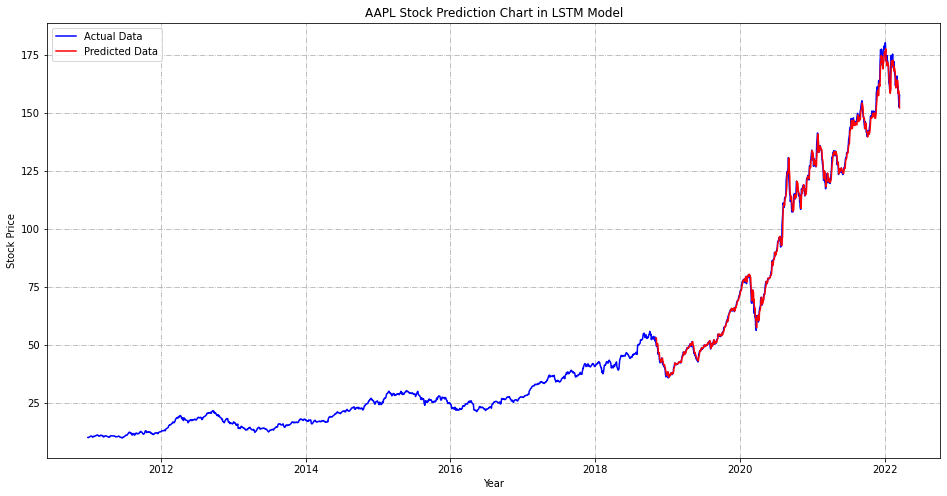

In [38]:
# df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
new_data_lstm.index = df['Date']
plt.figure(figsize=(16, 8))

test_lstm = new_data_lstm[1976:]
test_lstm['Predictions'] = forecasts_lstm
plt.plot(new_data_lstm['Adj_Close'], color='blue', label='Actual Data')
plt.plot(test_lstm['Predictions'], color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.title("AAPL Stock Prediction Chart in LSTM Model")
plt.legend()
plt.grid(linestyle='-.')
plt.show()

## 2.4 Model Performance Analysis
In this section, I focus on comparing error analysis results of three models.

In [39]:
error_analysis = pd.concat([df_error_lin, df_error_p, df_error_lstm], join="inner", axis=1)
print("Linear Regression model has better performance, because its RMSE is the lowest")
error_analysis

Linear Regression model has better performance, because its RMSE is the lowest


,Linear Regression,Prophet,LSTM
Mean Squared Error (MSE),0.116,40.484,4.131
Mean Absolute Error (MAE),0.169,4.618,1.403
Root Mean Squared Error (RMSE),0.341,6.363,2.032


# Conclusion
- **Task 1:**
    - Based on linear regression model analysis, I found out the mean absolute error of EMA is lower than SMA's, and It means that EMA method is more adequate to predict stock price.
- **Task 2:**
    - Based on Task 1 analysis result, I applied EMA as feature into models.
    - Compared with three models' error analysis results, the Linear Regression model has the best performance, because its root mean squared error is the lowest in three models.
